# **Extended Hubbard Hamiltonian for Quantum Dots**

The Hamiltonian for the extended spinless Hubbard model in a linear array of \(N\) quantum dots is provided. This Hamiltonian encompasses multiple interactions, from on-site energy to intersite Coulomb interactions.

## Hamiltonian Definition

The Hamiltonian $H_U$ is defined as:
$$
H_{U} = \sum_{i=1}^{N} \varepsilon_i n_i + \sum_{i=1}^{N} U_i n_i (n_i - 1) + \sum_{i=1}^{N-1} t_{i,i+1} \left( c^\dagger_i c_{i+1} + \text{h.c.} \right) + \sum_{i,j}^{N} V_{i,j} n_i n_j
$$

Where:
- $\varepsilon_i$: On-site energy levels of the $i^{th}$ dot.
- $U_i$: On-site Coulomb interaction strengths for the $i^{th}$ dot.
- $t_{i,i+1}$: Tunneling terms between the $i^{th}$ and $(i+1)^{th}$ dots.
- $V_{i,j}$: Intersite Coulomb interaction between the $v_i^{th}$ and $j^{th}$ dots.

# **SSH Model**

The Su–Schrieffer–Heeger (SSH) model is a fundamental framework that explains topological insulators in one-dimensional systems. It represents an electron moving along a dimerized lattice, with staggered hopping amplitudes, $v$ and $w$. Within each dimer, the electron hopping strength is $v$, and between adjacent dimers, it's $w$. The model's topological properties emerge when comparing these two strengths:
- Trivial phase: $v > w$
- Topological phase: $v < w$

## Quarter-Filling Phenomenon

At quarter-filling, five electrons are distributed amongst the dots. In the scenario where the array is in its trivial phase, electrons are evenly spread across the array, aligning themselves within each dimer. On the other hand, in a topological configuration at this filling, four electrons position themselves at the center of the array in a manner akin to the trivial phase. 

The distinction arises with the fifth electron, which doesn't reside within a dimer. Our primary focus is on this quarter-filling since the topologically interacting states are characterized by this fifth electron localizing at the extremes of the array.

**Energy Spectrum at Quarter-Filling:** 
  - Trivial Phase:
    - Single ground state with five electrons, 3.85 meV below the four- and six-electron states.
  - Topological Phase:
    - Nearly four-fold degeneracy involving four, five (two-fold degenerate), and six electrons.

##  Simulation of the SSH model

Parameters:
- Tunnel Coupling (t): $t \approx 3.4$ meV
- Intersite Coulomb Interaction (V): $V \approx 5$ meV
- On-site Coulomb Interaction (U): $U \approx 25$ meV
- Number of Sites (N): 10


Details:

- Trivial phase: $d_v = 7.7 \pm 0.1$ nm and $d_w = 10.1 \pm 0.2$ nm.
- Topological phase: $d_v = 9.6 \pm 0.4$ nm and $d_w = 7.8 \pm 0.6$ nm.


<img src="./images/energies.png" alt="Energies" style="width: 700px; display: inline-block; margin-right: 10px;"/>
<img src="./images/couplings.png" alt="System Model" style="width: 530px; display: inline-block;"/>


In [1]:
import qiskit as qk
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.algorithms.optimizers import COBYLA 
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.circuit.library import TwoLocal
from qiskit_aer.primitives import Estimator as AerEstimator
import numpy as np

In [2]:
def extended_hubbard_hamiltonian(N, epsilon:list, U:list, t:list, V:list):
    
    """Return the extended Hubbard Hamiltonian for given parameters."""

    hamiltonian = FermionicOp([])

    # On-site energy terms
    for i in range(N):
        hamiltonian += epsilon[i] * FermionicOp(f"N_{i}")

    # On-site Coulomb interaction terms
    for i in range(N):
        hamiltonian += U[i] * (FermionicOp(f"N_{i}") @ (FermionicOp(f"N_{i}")) - FermionicOp(f"N_{i}"))

    # Tunneling terms
    for i in range(N-1):
        hamiltonian += t[i] * (FermionicOp(f"+_{i} -_{i+1}") + FermionicOp(f"-_{i} +_{i+1}"))

    # Intersite Coulomb interaction terms
    for i in range(N):
        for j in range(N):
            hamiltonian += V[i][j] * FermionicOp(f"N_{i}") @ FermionicOp(f"N_{j}")

    return hamiltonian

### **We still need to get the values for $U_i$, $\varepsilon_i$, $V_{i,j}$ and $t_{j,j+1}$**

They are on this [link](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-022-04706-0/MediaObjects/41586_2022_4706_MOESM1_ESM.pdf)

In [3]:
from params import t_trivial, V_trivial, epsilon_trivial, U_trivial, N

In [4]:
# Now we transform the Hamiltonian into a qubit Hamiltonianm using the Jordan-Wigner transformation

H = extended_hubbard_hamiltonian(N, epsilon_trivial, U_trivial, t_trivial, V_trivial)
mapper  = JordanWignerMapper()
qubit_op = mapper.map(H)

/Users/rsnegrin/.local/share/virtualenvs/Qiskit-Hackathon-KYw6owOn/lib/python3.11/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


In [5]:
ansatz = TwoLocal(qubit_op.num_qubits, 'ry', 'cz', reps=1, entanglement='linear')

mixters = np.linspace(150, 600, 40)
results = []
for mixter in mixters:
    optimizer = COBYLA(maxiter=mixter)

    backend = qk.Aer.get_backend('statevector_simulator')


    # Setting up the VQE Algorithm
    aer_estimator = AerEstimator(run_options={"shots": 2048, "seed": 25})
    qe_program = VQE(aer_estimator, ansatz, optimizer)
    result = qe_program.compute_minimum_eigenvalue(operator=qubit_op)
    results.append(result.eigenvalue)

/Users/rsnegrin/.local/share/virtualenvs/Qiskit-Hackathon-KYw6owOn/lib/python3.11/site-packages/scipy/optimize/_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


Average: 0.35622247192383155


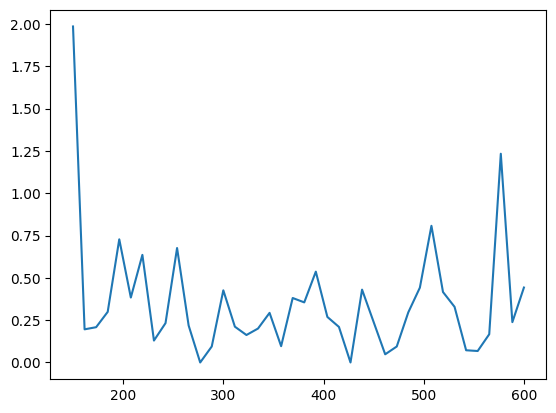

In [6]:
import matplotlib.pyplot as plt
plt.plot(mixters, results)
average = np.mean(results)
print(f"Average: {average}") # Im almost sure this is meV

### **Questions**:

1. **Energy Values:** I'm confused by the high energy values we're obtaining. For the trivial case, I would expect it to be around 3.85 meV. 

2. **Number of Electrons:** I don't know where we specify the number of electrons in the molecules within this model.

3. **Variability with VOQ:** VQE yields significantly different results each time. Even after experimenting with different mixers, the outputs seem to vary greatly.

**Note:** The data for the parameters was sourced from the referenced [paper.](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-022-04706-0/MediaObjects/41586_2022_4706_MOESM1_ESM.pdf)
